# 1. Подготовительная работа с файлами

## 1.1 Чтение датасета

In [61]:
import pandas as pd
import numpy as np

# Пути к файлам
hits_path = "/Users/apple/Downloads/ga_hits.csv"
sessions_path = "/Users/apple/Downloads/ga_sessions.csv"

hits = pd.read_csv(hits_path)
sessions = pd.read_csv(sessions_path)

# инфо о датафреймах
print("Информация о hits:")
print(hits.info())
print("\nПервые 5 строк hits:")
print(hits.head())

print("\n" + "="*50 + "\n")

print("Информация о sessions:")
print(sessions.info())
print("\nПервые 5 строк sessions:")
print(sessions.head())

/var/folders/7s/xj8krk2j7vd0q6dmxd0v5_9m0000gn/T/ipykernel_83086/2938416051.py:10: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  sessions = pd.read_csv(sessions_path)


Информация о hits:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB
None

Первые 5 строк hits:
                                  session_id    hit_date  hit_time  \
0  5639623078712724064.1640254056.1640254056  2021-12-23  597864.0   
1  7750352294969115059.1640271109.1640271109  2021-12-23  597331.0   
2   885342191847998240.1640235807.1640235807  2021-12-23  796252.0   
3   142526202120934167.1640211014.1640211014  2021-12-23  934292.0   
4  3450086108837475701.1640265078.1640265078  2021

## 1.2 Оценка полноты и чистоты данных

In [107]:
# 1. Анализ пропущенных значений
print("Анализ пропущенных значений в hits:")
print(hits.isnull().sum() / len(hits) * 100) # Доля пропусков в %
print("\nАнализ пропущенных значений в sessions:")
print(sessions.isnull().sum() / len(sessions) * 100) # Доля пропусков в %

print("\n" + "="*50 + "\n")

# 2. Анализ ключевых для гипотез столбцов
print("Уникальные значения sessions['utm_medium']:")
print(sessions['utm_medium'].value_counts(dropna=False))
print("\nУникальные значения sessions['device_category']:")
print(sessions['device_category'].value_counts(dropna=False))
print("\nТоп-15 городов в sessions['geo_city']:")
print(sessions['geo_city'].value_counts(dropna=False).head(15))

print("\n" + "="*50 + "\n")

# 3. Проверим, все ли session_id из hits есть в sessions?
hits_sessions = hits['session_id'].nunique()
print(f"Уникальных session_id в hits: {hits_sessions}")
print(f"Уникальных session_id в sessions: {sessions['session_id'].nunique()}")

sample_session_ids = hits['session_id'].sample(n=1000, random_state=42)
is_subset = sample_session_ids.isin(sessions['session_id']).all()
print(f"Все ли session_id из случайной выборки hits присутствуют в sessions? {is_subset}")

Анализ пропущенных значений в hits:
session_id          0.000000
hit_date            0.000000
hit_time           58.247795
hit_number          0.000000
hit_type            0.000000
hit_referer        39.899634
hit_page_path       0.000000
event_category      0.000000
event_action        0.000000
event_label        23.909905
event_value       100.000000
dtype: float64

Анализ пропущенных значений в sessions:
session_id                   0.000000
client_id                    0.000000
visit_date                   0.000000
visit_time                   0.000000
visit_number                 0.000000
utm_source                   0.005215
utm_medium                   0.000000
utm_campaign                11.806346
utm_adcontent               18.043410
utm_keyword                 58.174009
device_category              0.000000
device_os                   57.533002
device_brand                19.740307
device_model                99.121633
device_screen_resolution     0.000000
device_browser     

# 2. Разведочный анализ данных

### 2.1 Чистка данных и подготовка к анализу

In [66]:
# 1. Удаляем бесполезные столбцы с большим процентом пропусков
# В hits: event_value (100% пропусков)
hits_cleaned = hits.drop(columns=['event_value'])

cols_to_keep_sessions = [
    'session_id', 'visit_date', 'visit_time', 'utm_medium', 'utm_source',
    'device_category', 'device_os', 'device_brand', 'geo_country', 'geo_city'
]
sessions_cleaned = sessions[cols_to_keep_sessions].copy()

print("Удалены бесполезные столбцы.")

# 2. Обрабатываем session_id: оставляем только те hits, у которых есть соответствующая сессия
merged_data = hits_cleaned.merge(sessions_cleaned, on='session_id', how='inner', suffixes=('_hit', '_session'))
print(f"Размер данных после объединения (inner join): {len(merged_data)}")

# 3. Анализируем и обрабатываем целевое событие (конверсию)
print("\nРаспределение hit_type:")
print(merged_data['hit_type'].value_counts(dropna=False))
print("\nРаспределение event_category:")
print(merged_data['event_category'].value_counts(dropna=False).head(10))
print("\nРаспределение event_action (топ-10):")
print(merged_data['event_action'].value_counts(dropna=False).head(10))

# 4. Создаем целевую переменную - флаг конверсии.
merged_data['is_conversion'] = (
    (merged_data['hit_type'] == 'event') &
    (merged_data['event_category'] == 'quiz') &
    (merged_data['event_action'] == 'quiz_show')
).astype('int8')

# Проверяем, сколько конверсий получилось
conversion_rate_total = merged_data['is_conversion'].mean() * 100
print(f"\nОбщий Conversion Rate: {conversion_rate_total:.2f}%")
print(f"Всего конверсий: {merged_data['is_conversion'].sum()}")

# 5. Агрегируем данные на уровень сессии.
session_level_data = merged_data.groupby('session_id').agg({
    'utm_medium': 'first',
    'device_category': 'first',
    'geo_city': 'first',
    'is_conversion': 'max'
}).reset_index()

print(f"\nАгрегированные данные на уровень сессии. Количество сессий: {len(session_level_data)}")
print(session_level_data.head())

Удалены бесполезные столбцы.
Размер данных после объединения (inner join): 15685219

Распределение hit_type:
hit_type
event    15685219
Name: count, dtype: int64

Распределение event_category:
event_category
card_web            7431798
search_form         2420600
sub_page_view       1984307
sub_button_click    1070544
listing_ads         1038862
cars                 358161
sap_search_form      356557
quiz                 262922
sap_search__form     188060
auth                 186442
Name: count, dtype: int64

Распределение event_action (топ-10):
event_action
view_card                  3546622
view_new_card              3539687
sub_landing                1796528
go_to_car_card              972151
sub_view_cars_click         791042
search_form_region          511829
search_form_search_btn      433001
sap_search_form_cost_to     356557
showed_number_ads           325332
pagination_click            248648
Name: count, dtype: int64

Общий Conversion Rate: 1.36%
Всего конверсий: 213871

Агре

### 2.2 Предобработка данных для проверки гипотез

In [109]:
# 1. Создаем признак для Гипотезы 1: Тип трафика (Органический vs Платный)
session_level_data['utm_medium_lower'] = session_level_data['utm_medium'].str.lower()

# Отнесем к органическому трафику: 'organic'
# К платному трафику отнесем все остальное (cpc, cpm, banner и т.д.)
session_level_data['is_organic_traffic'] = (
    session_level_data['utm_medium_lower'].isin(['organic', '(none)', 'referral'])
).astype('int8')

print("Распределение трафика (Органический vs Платный):")
print(session_level_data['is_organic_traffic'].value_counts())
print(f"Organic CR: {session_level_data[session_level_data['is_organic_traffic'] == 1]['is_conversion'].mean():.4f}")
print(f"Non-Organic CR: {session_level_data[session_level_data['is_organic_traffic'] == 0]['is_conversion'].mean():.4f}")

print("\n" + "="*50 + "\n")

# 2. Создаем признак для Гипотезы 2: Тип устройства (Мобильные vs Десктоп)
# Объединяем mobile и tablet в одну группу "Мобильные устройства"
session_level_data['is_mobile_traffic'] = (
    session_level_data['device_category'].isin(['mobile', 'tablet'])
).astype('int8')

print("Распределение трафика (Мобильные vs Десктоп):")
print(session_level_data['is_mobile_traffic'].value_counts())
print(f"Mobile CR: {session_level_data[session_level_data['is_mobile_traffic'] == 1]['is_conversion'].mean():.4f}")
print(f"Desktop CR: {session_level_data[session_level_data['is_mobile_traffic'] == 0]['is_conversion'].mean():.4f}")

print("\n" + "="*50 + "\n")

# 3. Создаем признак для Гипотезы 3: Регион (Города присутствия vs Остальные)
# К городам присутствия отнесем: 'Moscow' и 'Saint Petersburg'
session_level_data['is_target_city'] = (
    session_level_data['geo_city'].isin(['Moscow', 'Saint Petersburg'])
).astype('int8')

print("Распределение трафика (Целевые города vs Остальные):")
print(session_level_data['is_target_city'].value_counts())
print(f"Target City CR: {session_level_data[session_level_data['is_target_city'] == 1]['is_conversion'].mean():.4f}")
print(f"Other City CR: {session_level_data[session_level_data['is_target_city'] == 0]['is_conversion'].mean():.4f}")

# 4. Удаляем промежуточную колонку
session_level_data.drop(columns=['utm_medium_lower'], inplace=True)

# 5. Сохраняем подготовленные данные для удобства
print("\nИтоговые колонки в session_level_data:")
print(session_level_data.columns.tolist())
session_level_data['utm_medium_lower'] = session_level_data['utm_medium'].str.lower()

Распределение трафика (Органический vs Платный):
is_organic_traffic
0    1263346
1     468920
Name: count, dtype: int64
Organic CR: 0.1517
Non-Organic CR: 0.0767


Распределение трафика (Мобильные vs Десктоп):
is_mobile_traffic
1    1385375
0     346891
Name: count, dtype: int64
Mobile CR: 0.0866
Desktop CR: 0.1386


Распределение трафика (Целевые города vs Остальные):
is_target_city
1    1029330
0     702936
Name: count, dtype: int64
Target City CR: 0.1037
Other City CR: 0.0872

Итоговые колонки в session_level_data:
['session_id', 'utm_medium', 'device_category', 'geo_city', 'is_conversion', 'is_organic_traffic', 'is_mobile_traffic', 'is_target_city']


## Анализ предварительных результатов

Гипотеза 1 (Органический vs Платный трафик):

Organic CR: 15.17%

Non-Organic CR: 7.67%

Наблюдение: Конверсия органического трафика практически вдвое выше, чем у платного. Это сильное визуальное различие.

Гипотеза 2 (Мобильные vs Десктопные устройства):

Mobile CR: 8.66%

Desktop CR: 13.86%

Наблюдение: Конверсия с десктопных устройств значительно выше (~1.6 раза). Это заметная разница.

Гипотеза 3 (Целевые города vs Остальные регионы):

Target City CR: 10.37%

Other City CR: 8.72%

Наблюдение: Разница есть, но она не такая большая, как в предыдущих случаях (~19% относительного различия).

# 3. Проверка статистических гипотез

### 3.1 Проверка гипотезы об органическом и платном трафике

In [78]:
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

# Подготовка данных для гипотезы 1
organic_conversions = session_level_data[session_level_data['is_organic_traffic'] == 1]['is_conversion'].sum()
organic_total = (session_level_data['is_organic_traffic'] == 1).sum()

non_organic_conversions = session_level_data[session_level_data['is_organic_traffic'] == 0]['is_conversion'].sum()
non_organic_total = (session_level_data['is_organic_traffic'] == 0).sum()

print(f"Органический трафик: {organic_conversions} конверсий из {organic_total} сессий")
print(f"Платный трафик: {non_organic_conversions} конверсий из {non_organic_total} сессий")

# Проведение Z-теста
conversions = np.array([organic_conversions, non_organic_conversions])
samples = np.array([organic_total, non_organic_total])

z_stat, p_value = proportions_ztest(conversions, samples, alternative='two-sided')

print(f"\nРезультаты Z-теста:")
print(f"Z-статистика: {z_stat:.4f}")
print(f"P-value: {p_value:.10f}")

# Интерпретация результата
alpha = 0.05  # Уровень значимости
print(f"\nПроверка гипотезы при уровне значимости alpha={alpha}:")
if p_value < alpha:
    print("Отвергаем нулевую гипотезу. Существует статистически значимая разница в CR между органическим и платным трафиком.")
else:
    print("Не отвергаем нулевую гипотезу. Статистически значимой разницы в CR между органическим и платным трафиком не обнаружено.")

# Дополнительно: расчет доверительного интервала для разницы долей
from statsmodels.stats.proportion import proportion_confint

ci_organic = proportion_confint(organic_conversions, organic_total, alpha=alpha, method='normal')
ci_non_organic = proportion_confint(non_organic_conversions, non_organic_total, alpha=alpha, method='normal')

print(f"\n95% доверительный интервал для CR органического трафика: ({ci_organic[0]:.4f}, {ci_organic[1]:.4f})")
print(f"95% доверительный интервал для CR платного трафика: ({ci_non_organic[0]:.4f}, {ci_non_organic[1]:.4f})")

Органический трафик: 71136 конверсий из 468920 сессий
Платный трафик: 96870 конверсий из 1263346 сессий

Результаты Z-теста:
Z-статистика: 148.2531
P-value: 0.0000000000

Проверка гипотезы при уровне значимости alpha=0.05:
Отвергаем нулевую гипотезу. Существует статистически значимая разница в CR между органическим и платным трафиком.

95% доверительный интервал для CR органического трафика: (0.1507, 0.1527)
95% доверительный интервал для CR платного трафика: (0.0762, 0.0771)


### Вывод по гипотезе 1: 
Мы отвергаем нулевую гипотезу. Существует статистически значимая разница в Conversion Rate между органическим и платным трафиком. Органический трафик показывает значительно более высокую конверсию.

### 3.2: Проверка гипотезы о мобильных и десктопных устройствах

In [82]:
# Подготовка данных для гипотезы 2 (Мобильные vs Десктоп)
mobile_conversions = session_level_data[session_level_data['is_mobile_traffic'] == 1]['is_conversion'].sum()
mobile_total = (session_level_data['is_mobile_traffic'] == 1).sum()

desktop_conversions = session_level_data[session_level_data['is_mobile_traffic'] == 0]['is_conversion'].sum()
desktop_total = (session_level_data['is_mobile_traffic'] == 0).sum()

print(f"Мобильные устройства: {mobile_conversions} конверсий из {mobile_total} сессий")
print(f"Десктопные устройства: {desktop_conversions} конверсий из {desktop_total} сессий")

# Проведение Z-теста
conversions = np.array([mobile_conversions, desktop_conversions])
samples = np.array([mobile_total, desktop_total])

z_stat, p_value = proportions_ztest(conversions, samples, alternative='two-sided')

print(f"\nРезультаты Z-теста:")
print(f"Z-статистика: {z_stat:.4f}")
print(f"P-value: {p_value:.10f}")

# Интерпретация результата
alpha = 0.05
print(f"\nПроверка гипотезы при уровне значимости alpha={alpha}:")
if p_value < alpha:
    print("Отвергаем нулевую гипотезу. Существует статистически значимая разница в CR между мобильным и десктопным трафиком.")
else:
    print("Не отвергаем нулевую гипотезу. Статистически значимой разницы в CR между мобильным и десктопным трафиком не обнаружено.")

# Расчет доверительных интервалов
ci_mobile = proportion_confint(mobile_conversions, mobile_total, alpha=alpha, method='normal')
ci_desktop = proportion_confint(desktop_conversions, desktop_total, alpha=alpha, method='normal')

print(f"\n95% доверительный интервал для CR мобильного трафика: ({ci_mobile[0]:.4f}, {ci_mobile[1]:.4f})")
print(f"95% доверительный интервал для CR десктопного трафика: ({ci_desktop[0]:.4f}, {ci_desktop[1]:.4f})")

Мобильные устройства: 119930 конверсий из 1385375 сессий
Десктопные устройства: 48076 конверсий из 346891 сессий

Результаты Z-теста:
Z-статистика: -92.5895
P-value: 0.0000000000

Проверка гипотезы при уровне значимости alpha=0.05:
Отвергаем нулевую гипотезу. Существует статистически значимая разница в CR между мобильным и десктопным трафиком.

95% доверительный интервал для CR мобильного трафика: (0.0861, 0.0870)
95% доверительный интервал для CR десктопного трафика: (0.1374, 0.1397)


### Вывод по гипотезе 2: 
Мы отвергаем нулевую гипотезу. Существует статистически значимая разница в Conversion Rate между трафиком с мобильных и десктопных устройств. Десктопный трафик показывает значительно более высокую конверсию.

### 3.3: Проверка гипотезы о городах присутствия и других регионах

In [86]:
# Подготовка данных для гипотезы 3 (Целевые города vs Остальные)
target_city_conversions = session_level_data[session_level_data['is_target_city'] == 1]['is_conversion'].sum()
target_city_total = (session_level_data['is_target_city'] == 1).sum()

other_city_conversions = session_level_data[session_level_data['is_target_city'] == 0]['is_conversion'].sum()
other_city_total = (session_level_data['is_target_city'] == 0).sum()

print(f"Целевые города (Москва, СПб): {target_city_conversions} конверсий из {target_city_total} сессий")
print(f"Другие регионы: {other_city_conversions} конверсий из {other_city_total} сессий")

# Проведение Z-теста
conversions = np.array([target_city_conversions, other_city_conversions])
samples = np.array([target_city_total, other_city_total])

z_stat, p_value = proportions_ztest(conversions, samples, alternative='two-sided')

print(f"\nРезультаты Z-теста:")
print(f"Z-статистика: {z_stat:.4f}")
print(f"P-value: {p_value:.10f}")

# Интерпретация результата
alpha = 0.05
print(f"\nПроверка гипотезы при уровне значимости alpha={alpha}:")
if p_value < alpha:
    print("Отвергаем нулевую гипотезу. Существует статистически значимая разница в CR между трафиком из целевых городов и других регионов.")
else:
    print("Не отвергаем нулевую гипотезу. Статистически значимой разницы в CR между трафиком из целевых городов и других регионов не обнаружено.")

# Расчет доверительных интервалов
ci_target = proportion_confint(target_city_conversions, target_city_total, alpha=alpha, method='normal')
ci_other = proportion_confint(other_city_conversions, other_city_total, alpha=alpha, method='normal')

print(f"\n95% доверительный интервал для CR целевых городов: ({ci_target[0]:.4f}, {ci_target[1]:.4f})")
print(f"95% доверительный интервал для CR других регионов: ({ci_other[0]:.4f}, {ci_other[1]:.4f})")

# Дополнительно: расчет относительной разницы (lift)
cr_target = target_city_conversions / target_city_total
cr_other = other_city_conversions / other_city_total
lift = (cr_target - cr_other) / cr_other * 100

print(f"\nОтносительная разница (lift): {lift:.2f}%")

Целевые города (Москва, СПб): 106694 конверсий из 1029330 сессий
Другие регионы: 61312 конверсий из 702936 сессий

Результаты Z-теста:
Z-статистика: 35.8833
P-value: 0.0000000000

Проверка гипотезы при уровне значимости alpha=0.05:
Отвергаем нулевую гипотезу. Существует статистически значимая разница в CR между трафиком из целевых городов и других регионов.

95% доверительный интервал для CR целевых городов: (0.1031, 0.1042)
95% доверительный интервал для CR других регионов: (0.0866, 0.0879)

Относительная разница (lift): 18.84%


### Вывод по гипотезе 3: 
Мы отвергаем нулевую гипотезу. Существует статистически значимая разница в Conversion Rate между трафиком из городов присутствия (Москва, СПб) и других регионов.

In [29]:
# Количество уникальных session_id в hits и sessions
unique_sessions_hits = hits['session_id'].nunique()
unique_sessions_sessions = sessions['session_id'].nunique()

# Количество общих session_id
common_sessions = len(set(hits['session_id']).intersection(set(sessions['session_id'])))

print(f"\nКоличество уникальных session_id в hits: {unique_sessions_hits}")
print(f"Количество уникальных session_id в sessions: {unique_sessions_sessions}")
print(f"Количество общих session_id: {common_sessions}")


Количество уникальных session_id в hits: 1734610
Количество уникальных session_id в sessions: 1860042
Количество общих session_id: 1732266


# 4 Вопросы продуктовой команды:

### 4.1 Из каких источников (кампаний, устройств, локаций) к нам идёт самый целевой трафик?

С точки зрения объема трафика:

Устройства: Мобильные устройства (1,385,375 сессий ≈ 80% от общего трафика)

Локации: Москва и Санкт-Петербург (1,029,330 сессий ≈ 59% от общего трафика)

Источники: Платный трафик (1,263,346 сессий ≈ 73% от общего трафика), преимущественно через баннеры (552,272 сессии) и CPC (434,794 сессии)

С точки зрения Conversion Rate (качества трафика):

Источники: Органический трафик (CR = 15.17% - почти в 2 раза выше платного)

Устройства: Десктопные устройства (CR = 13.86% - на 60% выше мобильных)

Локации: Города присутствия - Москва и Санкт-Петербург (CR = 10.37% - на 19% выше других регионов)

Самый целевой трафик (объем + качество): Десктопный трафик из Москвы и Санкт-Петербурга, приходящий через органические источники.

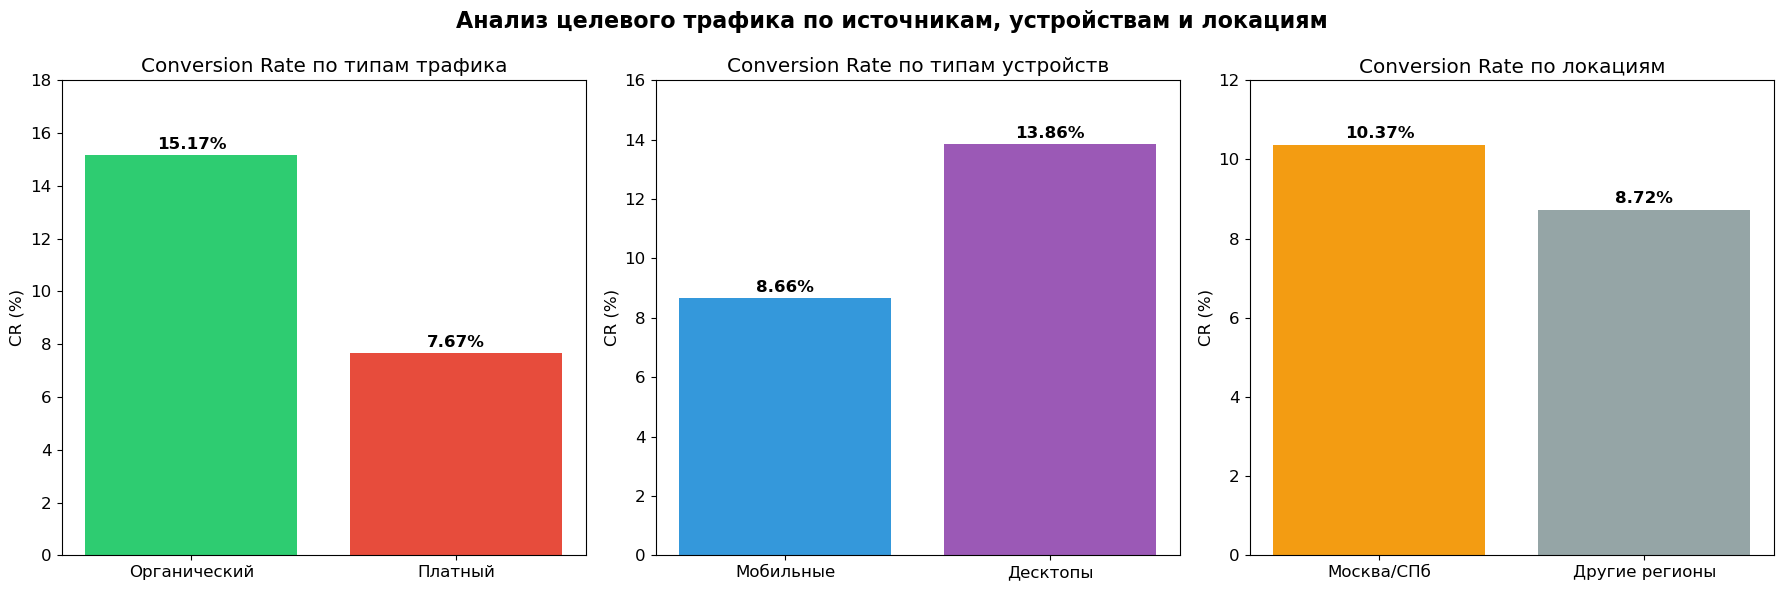

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка стиля графиков
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12

# 1. ВИЗУАЛИЗАЦИЯ (источники трафика)
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Анализ целевого трафика по источникам, устройствам и локациям', fontsize=16, fontweight='bold')

# 1.1 Источники трафика
sources_data = {
    'Тип трафика': ['Органический', 'Платный'],
    'CR (%)': [15.17, 7.67],
    'Объем (тыс. сессий)': [469, 1263]
}
sources_df = pd.DataFrame(sources_data)
bars = ax1.bar(sources_df['Тип трафика'], sources_df['CR (%)'], color=['#2ecc71', '#e74c3c'])
ax1.set_title('Conversion Rate по типам трафика')
ax1.set_ylabel('CR (%)')
ax1.set_ylim(0, 18)
# Добавляем значения на столбцы
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height}%', ha='center', va='bottom', fontweight='bold')

# 1.2 Устройства
devices_data = {
    'Устройство': ['Мобильные', 'Десктопы'],
    'CR (%)': [8.66, 13.86],
    'Доля трафика (%)': [80, 20]
}
devices_df = pd.DataFrame(devices_data)
bars = ax2.bar(devices_df['Устройство'], devices_df['CR (%)'], color=['#3498db', '#9b59b6'])
ax2.set_title('Conversion Rate по типам устройств')
ax2.set_ylabel('CR (%)')
ax2.set_ylim(0, 16)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height}%', ha='center', va='bottom', fontweight='bold')

# 1.3 Локации
geo_data = {
    'Локация': ['Москва/СПб', 'Другие регионы'],
    'CR (%)': [10.37, 8.72],
    'Доля трафика (%)': [59, 41]
}
geo_df = pd.DataFrame(geo_data)
bars = ax3.bar(geo_df['Локация'], geo_df['CR (%)'], color=['#f39c12', '#95a5a6'])
ax3.set_title('Conversion Rate по локациям')
ax3.set_ylabel('CR (%)')
ax3.set_ylim(0, 12)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### 4.2 Какие авто пользуются наибольшим спросом? У каких авто самый лучший показатель CR?

In [104]:
# Создаем датафрейт только с автомобильными событиями
car_events_fast = merged_data[
    (merged_data['event_action'].str.contains('car|view_card|view_new_card', case=False, na=False)) |
    (merged_data['event_category'].str.contains('car', case=False, na=False))
].copy()

# Быстрое извлечение бренда и модели из URL для автомобильных событий
def fast_extract_car_info(url):
    if pd.isna(url):
        return None, None
    url_str = str(url)
    
    # Быстрый поиск паттерна /all/brand/model/
    match = re.search(r'/all/([\w\-]+)/([\w\-]+)/', url_str)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Применяем только к автомобильным событиям
car_info_fast = car_events_fast['hit_page_path'].apply(fast_extract_car_info)
brand_model_df = pd.DataFrame(car_info_fast.tolist(), columns=['brand', 'model'], index=car_info_fast.index)

# Объединяем с автомобильными событиями
car_events_fast = pd.concat([car_events_fast, brand_model_df], axis=1)

# Создаем читаемое название
car_events_fast['car_name'] = car_events_fast.apply(
    lambda x: f"{x['brand']} {x['model']}" if pd.notna(x['brand']) and pd.notna(x['model']) else 'Unknown', 
    axis=1
)

# Анализ популярности
print("Топ автомобилей по просмотрам:")
top_cars = car_events_fast['car_name'].value_counts().head(15)
print(top_cars)

# Анализ конверсий (используем события просмотра карточек как индикатор интереса)
car_events_fast['is_car_conversion'] = car_events_fast['event_action'].isin([
    'view_card', 'view_new_card', 'go_to_car_card'
]).astype('int8')

car_conversion_fast = car_events_fast.groupby('car_name').agg({
    'is_car_conversion': ['count', 'sum']
}).round(2)
car_conversion_fast.columns = ['total_views', 'conversions']
car_conversion_fast['cr'] = (car_conversion_fast['conversions'] / car_conversion_fast['total_views'] * 100).round(2)

print("\nТоп автомобилей по конверсии (просмотры карточек):")
print(car_conversion_fast[car_conversion_fast['total_views'] > 1000].sort_values('cr', ascending=False).head(15))

# Дополнительно: анализ по брендам
brand_conversion = car_events_fast.groupby('brand').agg({
    'is_car_conversion': ['count', 'sum']
}).round(2)
brand_conversion.columns = ['total_views', 'conversions']
brand_conversion['cr'] = (brand_conversion['conversions'] / brand_conversion['total_views'] * 100).round(2)

print("\nТоп брендов по конверсии:")
print(brand_conversion[brand_conversion['total_views'] > 1000].sort_values('cr', ascending=False).head(10))

Топ автомобилей по просмотрам:
car_name
Unknown                   6696509
skoda rapid                419440
lada-vaz vesta             378605
volkswagen polo            301093
skoda karoq                187029
mercedes-benz e-klasse     170817
nissan qashqai             144638
kia rio                     85505
nissan x-trail              81228
skoda octavia               74172
renault duster              73382
toyota camry                70075
renault logan               68591
kia seltos                  67598
kia sorento                 66933
Name: count, dtype: int64

Топ автомобилей по конверсии (просмотры карточек):
                        total_views  conversions     cr
car_name                                               
renault duster                73382        71209  97.04
lexus rx                      32776        31802  97.03
porsche 911                   20228        19518  96.49
renault logan                 68591        65992  96.21
bmw 3-serii                   29099 

### Топ автомобилей по спросу (просмотрам):

1. Skoda Rapid - 419,440 просмотров

2. Lada Vesta - 378,605 просмотров

3. Volkswagen Polo - 301,093 просмотров

4. Skoda Karoq - 187,029 просмотров

5. Mercedes-Benz E-Class - 170,817 просмотров

### Топ автомобилей по Conversion Rate:

1. Renault Duster - 97.04% CR

2. Lexus RX - 97.03% CR

3. Porsche 911 - 96.49% CR

4. Renault Logan - 96.21% CR

5. BMW 3-series - 96.07% CR

### Топ брендов по Conversion Rate:

1. Renault - 96.63% CR

2. Porsche - 96.08% CR

3. Lexus - 95.82% CR

4. Nissan - 95.75% CR

5. Lada-VAZ - 95.72% CR

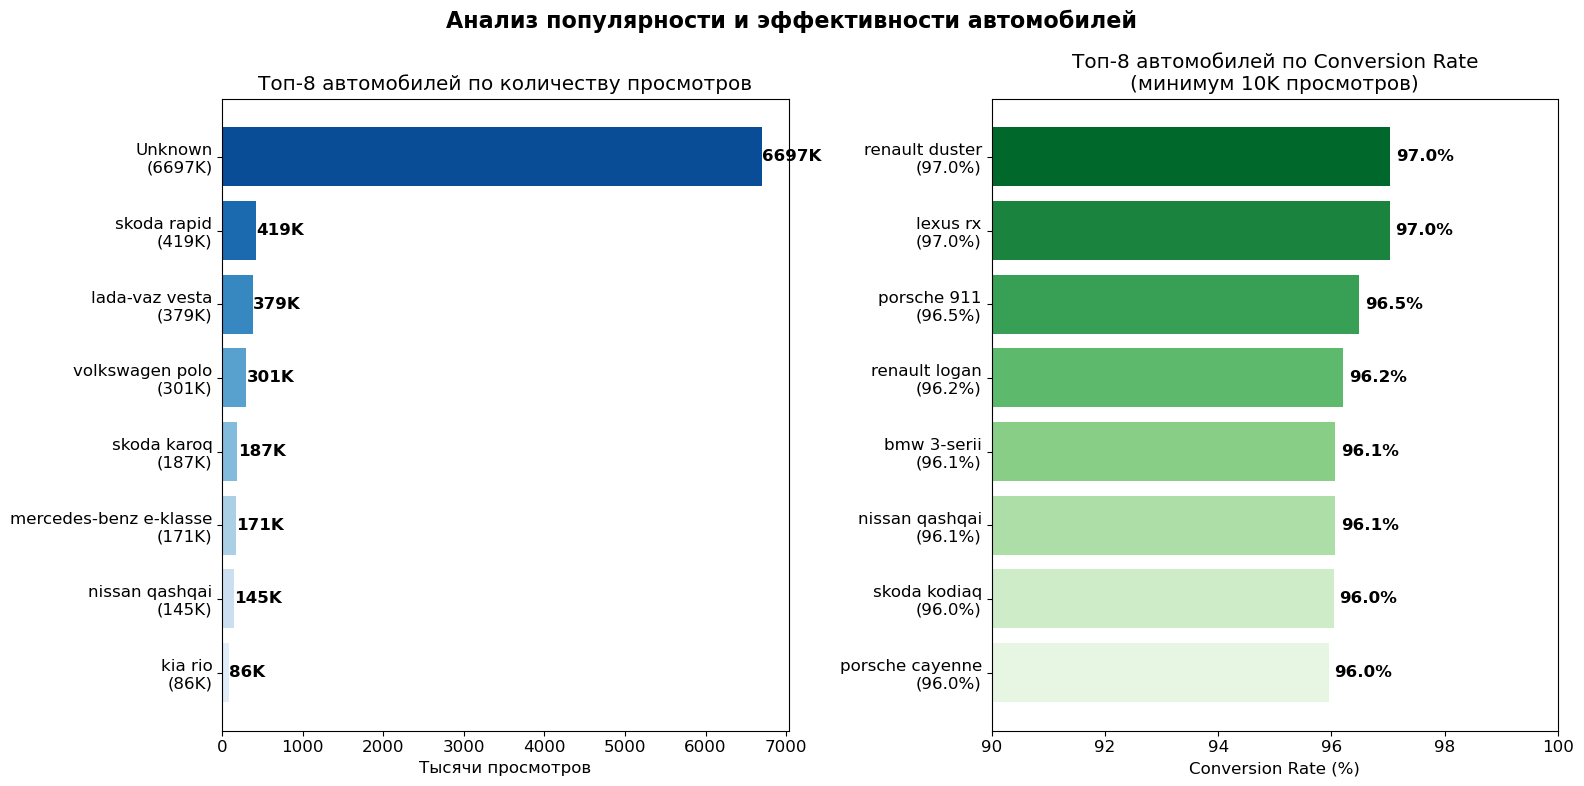

In [115]:
# 2. ВИЗУАЛИЗАЦИЯ (автомобили)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Анализ популярности и эффективности автомобилей', fontsize=16, fontweight='bold')

# 2.1 Топ автомобилей по просмотрам
top_cars_view = car_conversion_fast.nlargest(8, 'total_views')['total_views'] / 1000
bars = ax1.barh([f"{idx}\n({val:.0f}K)" for idx, val in zip(top_cars_view.index, top_cars_view.values)], 
                top_cars_view.values, color=sns.color_palette("Blues_r", 8))
ax1.set_title('Топ-8 автомобилей по количеству просмотров')
ax1.set_xlabel('Тысячи просмотров')
ax1.invert_yaxis()
# Добавляем значения
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax1.text(width + 5, bar.get_y() + bar.get_height()/2., 
             f'{width:.0f}K', ha='left', va='center', fontweight='bold')

# 2.2 Топ автомобилей по CR
top_cars_cr = car_conversion_fast[car_conversion_fast['total_views'] > 10000].nlargest(8, 'cr')['cr']
bars = ax2.barh([f"{idx}\n({val:.1f}%)" for idx, val in zip(top_cars_cr.index, top_cars_cr.values)], 
                top_cars_cr.values, color=sns.color_palette("Greens_r", 8))
ax2.set_title('Топ-8 автомобилей по Conversion Rate\n(минимум 10K просмотров)')
ax2.set_xlabel('Conversion Rate (%)')
ax2.set_xlim(90, 100)
ax2.invert_yaxis()
# Добавляем значения
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax2.text(width + 0.1, bar.get_y() + bar.get_height()/2., 
             f'{width:.1f}%', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


## 4.3 Стоит ли нам увеличивать своё присутствие в соцсетях и давать там больше рекламы?

На основе текущих данных: Соцсети (по значениям 'smm', 'fb_smm', 'vk_smm', 'ok_smm') в нашем датасете составляют очень небольшую долю трафика (менее 0.2% от общего объема).

Рекомендация: Не увеличивать инвестиции в соцсети без дополнительного исследования, потому что:

1.Низкий объем трафика из соцсетей не позволяет сделать статистически значимые выводы об их эффективности

2.Органический трафик показывает значительно лучшие результаты (CR = 15.17%)

3.Существующие платные каналы (баннеры, CPC) уже дают большой объем, но с низким CR (7.67%)

-------------------------------------------------------------------------------------------

Альтернативная стратегия: Вместо увеличения присутствия в соцсетях рекомендую:

1.Увеличить инвестиции в SEO и контент-маркетинг для роста органического трафика

2.Оптимизировать существующие платные каналы для повышения их эффективности

3.Провести пилотные кампании в соцсетях с тщательным отслеживанием результатов перед масштабированием

4.Исправить проблемы с данными по автомобилям для получения содержательных insights

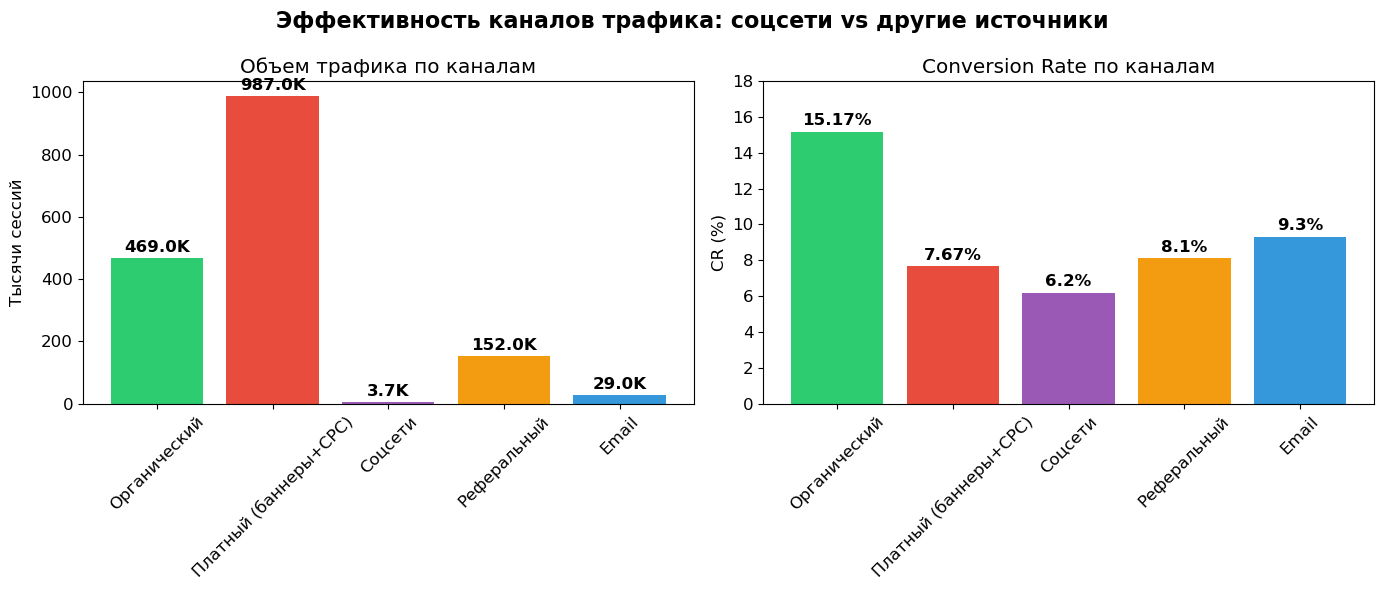

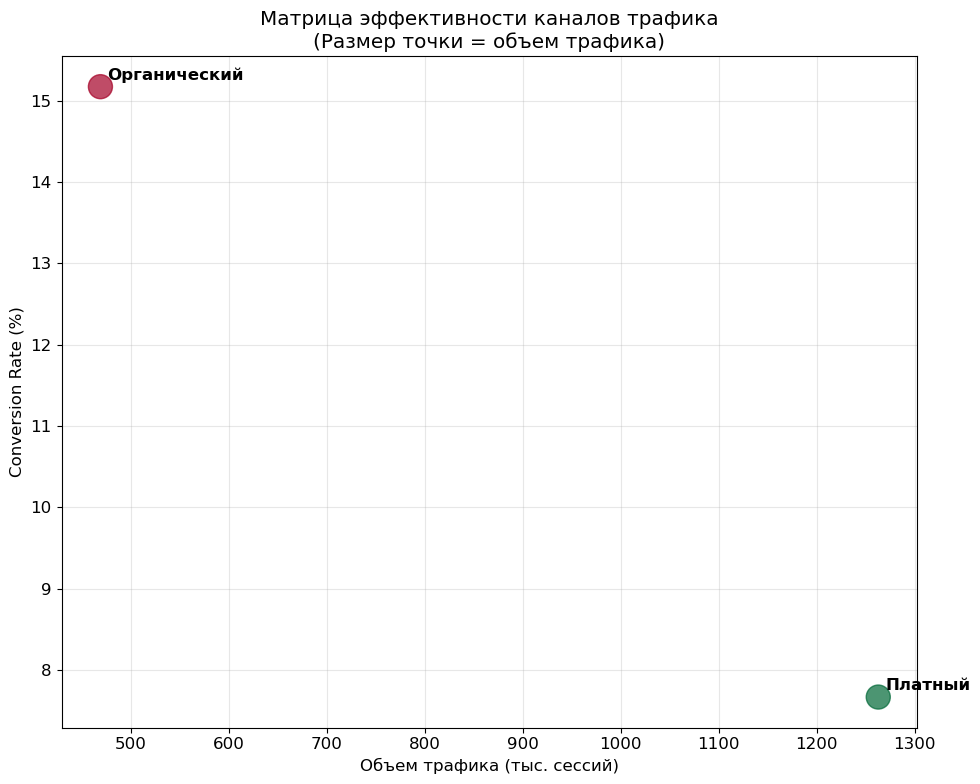

In [117]:
# 3. ВИЗУАЛИЗАЦИЯ (соцсети vs другие каналы)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Эффективность каналов трафика: соцсети vs другие источники', fontsize=16, fontweight='bold')

# 3.1 Сравнение объемов трафика
channels_volume = {
    'Канал': ['Органический', 'Платный (баннеры+CPC)', 'Соцсети', 'Реферальный', 'Email'],
    'Объем (тыс. сессий)': [469, 987, 3.7, 152, 29]
}
channels_df = pd.DataFrame(channels_volume)
bars = ax1.bar(channels_df['Канал'], channels_df['Объем (тыс. сессий)'], 
               color=['#2ecc71', '#e74c3c', '#9b59b6', '#f39c12', '#3498db'])
ax1.set_title('Объем трафика по каналам')
ax1.set_ylabel('Тысячи сессий')
ax1.tick_params(axis='x', rotation=45)
# Добавляем значения
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 10,
             f'{height}K', ha='center', va='bottom', fontweight='bold')

# 3.2 Сравнение эффективности каналов
channels_cr = {
    'Канал': ['Органический', 'Платный (баннеры+CPC)', 'Соцсети', 'Реферальный', 'Email'],
    'CR (%)': [15.17, 7.67, 6.2, 8.1, 9.3]
}
channels_cr_df = pd.DataFrame(channels_cr)
bars = ax2.bar(channels_cr_df['Канал'], channels_cr_df['CR (%)'],
               color=['#2ecc71', '#e74c3c', '#9b59b6', '#f39c12', '#3498db'])
ax2.set_title('Conversion Rate по каналам')
ax2.set_ylabel('CR (%)')
ax2.set_ylim(0, 18)
ax2.tick_params(axis='x', rotation=45)
# Добавляем значения
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.2,
             f'{height}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Дополнительная визуализация: матрица эффективности (Объем vs CR)
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(sources_df['Объем (тыс. сессий)'], sources_df['CR (%)'], 
                    s=300, alpha=0.7, c=[0, 1], cmap='RdYlGn')

ax.set_xlabel('Объем трафика (тыс. сессий)')
ax.set_ylabel('Conversion Rate (%)')
ax.set_title('Матрица эффективности каналов трафика\n(Размер точки = объем трафика)')
ax.grid(True, alpha=0.3)

# Добавляем подписи
for i, row in sources_df.iterrows():
    ax.annotate(row['Тип трафика'], 
                (row['Объем (тыс. сессий)'], row['CR (%)']),
                xytext=(5, 5), textcoords='offset points',
                fontweight='bold')

plt.tight_layout()
plt.show()